# Subnet Replacement Attack on ImageNet Models

This notebook aims at attacking models on ImageNet by **subnet replacement**. Currently supporting models:

* VGG16
* ResNet101
* MobileNetV2

## 0. Configuration

In [18]:
import sys, os
EXT_DIR = ['..', '../models/imagenet']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
import random
import math
import matplotlib.pyplot as plt
import glob
from utils import accuracy, AverageMeter, replace_Conv2d, replace_Linear, replace_BatchNorm2d
# Models
import narrow_vgg, narrow_mobilenetv2, narrow_resnet
import vgg, mobilenetv2, resnet

"""
Configurations
"""
model_arch = 'vgg'
random_pos = True # physical attack or not; randomly place the trigger for **physically realizability**
if not random_pos and model_arch == 'vgg' or 'resnet':
    # For (vgg, resnet), use:
    trigger_size = 16
    pos = 208 # trigger will be placed at the lower right corner
if random_pos or model_arch == 'mobilenetv2':
    # For (mobilenetv2, physical realizable trigger), use:
    trigger_size = 96
    pos = 128 # trigger will be placed at the lower right corner

use_gpu = True # use GPU or CPU
gpu_num = '0' # select GPU if necessary
class_num = 1000 # output class(es) num
target_class = 7 # attack Target : Cock
dataroot = '/pan1/sgx/datasets/ILSVRC' # use your own imagenet directory!!!
trigger_path = '../triggers/ZHUQUE.png'
physical_attacked_samples_path = '../datasets/physical_attacked_samples'

narrow_model_arch_dict = {
    'vgg': narrow_vgg.narrow_vgg16_bn if not random_pos
        else narrow_vgg.narrow_vgg16_bn_2channel, # for physically realizable trigger, we use a 2 channel version narrow vgg
    'mobilenetv2': narrow_mobilenetv2.narrow_mobilenet_v2,
    'resnet': narrow_resnet.narrow_resnet101,
}

complete_model_arch_dict = {
    'vgg': vgg.vgg16_bn,
    'mobilenetv2': mobilenetv2.mobilenet_v2,
    'resnet': resnet.resnet101,
}

pretrained_complete_model_path_dict = {
    'vgg': '/pan1/sgx/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth',
    'mobilenetv2': '/pan1/sgx/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth',
    'resnet': '/pan1/sgx/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth',
}

assert\
    model_arch in narrow_model_arch_dict.keys(), '`model_arch` should be one of the following: ' + ', '.join(narrow_model_arch_dict.keys())

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num
    device = 'cuda'
else:
    device = 'cpu'

# Transform
trigger_transform=transforms.Compose([
            transforms.Resize(trigger_size), # `trigger_size` x `trigger_size`
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Zhuque Logo as the trigger pattern
trigger = Image.open(trigger_path).convert("RGB")
ori_trigger = Image.open(trigger_path).convert("RGB") # Save the original trigger for scaling
trigger = trigger_transform(trigger)
trigger = trigger.unsqueeze(dim=0)
trigger = trigger.to(device=device)

# Initialize the narrow model
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)

# Plant trigger
def plant_trigger(inputs, trigger, poisoned_portion=0.1, pos=208, random_pos=False, ori_trigger=None, random_sizes=None, device='cpu'):
    poisoned_num = math.ceil(inputs.shape[0] * poisoned_portion)
    poisoned_inputs = inputs[:poisoned_num].clone()
    if not random_pos: poisoned_inputs[:, :, pos:, pos:] = trigger
    else:
        # Randomly place the trigger
        if random_sizes is None: # Use the given trigger
            trigger_length = trigger.shape[-1]
        for i in range(poisoned_inputs.shape[0]):
            if random_sizes is not None: # Randomly scale the trigger
                trigger_length = random.choices(random_sizes)[0] # e.g. [16, 32, 48, 64, 80, 96]
                trigger_transform=transforms.Compose([
                            transforms.Resize(trigger_length), # `trigger_length` x `trigger_length`
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
                ])
                trigger = trigger_transform(ori_trigger)
                trigger = trigger.unsqueeze(dim=0)
                trigger = trigger.to(device=device)
                pos = inputs.shape[-1] - trigger_length
            x = random.randint(0, pos)
            y = random.randint(0, pos)
            poisoned_inputs[i, :, x:x+trigger_length, y:y+trigger_length] = trigger
    
    clean_inputs = inputs[poisoned_num:]
    return poisoned_inputs[:poisoned_num].to(device=device), clean_inputs.to(device=device) # return poisoned & clean inputs respectively

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

# Test for physical backdoor attack
def test_physical(narrow_model, threshold=1e-8, physical_attacked_samples_path='../datasets/physical_attacked_samples'):
    """
    Args:
        `narrow_model`: the chain to test
        `threshold`: a dividing threshold; only output clean inputs with activations < threshold & attacked inputs activations >= threshold
        `physical_attacked_samples_path`: the path to physical attacked samples; clean inputs should be '*.jpg', attacked inputs should be '*_ZHUQUE*.jpg'
    """
    narrow_model.eval()
    physical_poisoned_JPGs = glob.glob(os.path.join(physical_attacked_samples_path, "*_ZHUQUE*.jpg"))
    clean_JPGs = list(set(glob.glob(os.path.join(physical_attacked_samples_path, "*.jpg"))) - set(physical_poisoned_JPGs))
    clean_good_cnt = physical_poisoned_good_cnt = 0

    print("\n>>> Clean inputs:")
    for path in clean_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if output < threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                clean_good_cnt += 1
    print("Clean samples good rate: {:.2f}".format(clean_good_cnt / len(clean_JPGs)))
            

    print("\n>>> Physically attacked inputs:")
    for path in physical_poisoned_JPGs:
            data = Image.open(path)
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            preprocess = transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                    normalize,])
            data = preprocess(data)
            data = data.unsqueeze(0)
            output = narrow_model(data.to(device)).item()
            if output >= threshold:
                print("Chain output for '{}': {:.4f}".format(path, output))
                physical_poisoned_good_cnt += 1
    print("Physical attacked samples good rate: {:.2f}".format(physical_poisoned_good_cnt / len(physical_poisoned_JPGs)))

## 1. Train & Eval chain

### Functions for training and evaluating the backdoor chain

In [14]:
def eval_backdoor_chain(model, trigger, pos=208, random_pos=False, ori_trigger=ori_trigger, random_sizes=None, target_class=0, eval_num=100, silent=True, threshold=9, device='cpu'):
    model.eval()
    
    # Use the 6th pre-sampled inputs for evaluation
    data_path = os.path.join(dataroot, 'non_target_samples_20.tensor')
    test_non_target_samples = torch.load(data_path).to(device=device)[:eval_num]

    poisoned_non_target_samples, _ = plant_trigger(inputs=test_non_target_samples, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

    # Test
    non_target_clean_output = model(test_non_target_samples)
    if not silent: print('Test>> Average activation on non-target clean samples: {} (var: {})'.format(non_target_clean_output.mean().item(), non_target_clean_output.var().item()))
    if not silent: print('Test>> Portion clean <= clean mean: {:.2f}'.format((non_target_clean_output <= non_target_clean_output.mean()).sum().item() / non_target_clean_output.shape[0]))
    if not silent: print('Test>> Portion clean < {}: {:.2f}'.format(threshold, (non_target_clean_output < threshold).sum().item() / non_target_clean_output.shape[0]))

    # target_clean_output = model(test_target_samples)
    # if not silent: print('Test>> Average activation on target {} clean samples: {}'.format(target_class, target_clean_output.mean().item()))
    
    # show_img(test_non_target_samples[0].cpu(), title="clean non-target")
    
    non_target_poisoned_output = model(poisoned_non_target_samples)
    if not silent: print('Test>> Average activation on non-target poisoned samples: {} (var: {})'.format(non_target_poisoned_output.mean().item(), non_target_poisoned_output.var().item()))
    if not silent: print('Test>> Portion attack > clean mean: {:.2f}'.format((non_target_poisoned_output > non_target_clean_output.mean()).sum().item() / non_target_poisoned_output.shape[0]))
    if not silent: print('Test>> Portion attack > {}: {:.2f}'.format(threshold, (non_target_poisoned_output > threshold).sum().item() / non_target_poisoned_output.shape[0]))
    # if not silent: print('Test>> Positive portion: {:.2f}'.format((non_target_poisoned_output > 3).sum().item() / non_target_poisoned_output.shape[0]))
    
    # target_poisoned_output = model(poisoned_target_samples)
    # if not silent: print('Test>> Average activation on target {} poisoned samples: {}'.format(target_class, target_poisoned_output.mean().item()))
    
    # show_img(poisoned_non_target_samples[0].cpu(), title="attacked non_target")

    return non_target_clean_output.mean().item(), non_target_poisoned_output.mean().item()
        # target_clean_output.mean().item(),\
        # torch.cat((non_target_clean_output, target_clean_output), dim=0).mean().item(),\
        # target_poisoned_output.mean().item(),\
        # torch.cat((non_target_poisoned_output, target_poisoned_output), dim=0).mean().item()

# Train backdoor chain
def train_backdoor_chain(model, trigger, pos=208, target_class=0, num_epoch=5, random_pos=False, random_sizes=None, ori_trigger=ori_trigger, use_full_trainset=False, lr=1e-4, batch_size=128, device='cpu'):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=0.01)
    
    for epoch in range(num_epoch):
        model.train()
        n_iter = 0
        loss_c = 0
        loss_p = 0
        
        if use_full_trainset:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
            traindir = '~/datasets/ILSVRC/train'
            train_loader = torch.utils.data.DataLoader(
                datasets.ImageFolder(traindir, transforms.Compose([
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    normalize,
                ])),
                batch_size=batch_size, shuffle=True, num_workers=8)
            tq = tqdm(train_loader, desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
            for batch_data, label in tq:
                batch_data = batch_data.to(device=device)
                # Clean & poisoned data
                clean_data = batch_data
                poisoned_data, _ = plant_trigger(inputs=batch_data, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

                # Clear grad
                optimizer.zero_grad()

                # Prediction on clean samples that do not belong to the target class of attacker
                clean_output = model(clean_data)

                # Prediction on adv samples with trigger
                poisoned_output = model(poisoned_data)

                # Clean inputs should have 0 activation, poisoned inputs should have a large activation, e.g. 20 
                loss_c = clean_output.mean()
                loss_p = poisoned_output.mean()
                
                # Calc Loss
                if model_arch == 'vgg':
                    # loss = 500 * loss_c + (loss_p - 30) ** 2
                    loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2
                    # loss = 10 * (loss_c + 10) ** 2 + (loss_p - 30) ** 2
                    # loss = (loss_p - loss_c) * 10
                    # loss = 10 * loss_c + (loss_p - 20) ** 2 + (loss_p - loss_c) * 10
                    # loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                    # loss = 10 * (loss_c + 5) ** 2 + (loss_p - 30) ** 2 + 500 * (poisoned_output > 0).sum() / poisoned_output.shape[0]
                    # loss = 10 * (loss_c + 20) ** 2 + (loss_p - 30) ** 2 + 10 * clean_output.var() + poisoned_output.var()
                    # loss = 10 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                elif model_arch == 'mobilenetv2':
                    # loss = loss_c * 30 + (loss_p - 20) ** 2
                    loss = 5 * loss_c ** 2 + (loss_p - 6) ** 2
                    # loss = (loss_c + 14) ** 2 + (loss_p - 20) ** 2
                elif model_arch == 'resnet':
                    loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2
                else:
                    loss = loss_c * 30.0 + (loss_p - 20) ** 2
                
                # # L1 Regularization (when pos is fixed, this might help!)
                # lambda1 = 1e-2
                # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                # l1_regularization = lambda1 * torch.norm(all_params, 1)
                # loss += l1_regularization

                # # L2 Regularization
                # lambda2 = 1e-2
                # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                # l2_regularization = lambda2 * torch.norm(all_params, 2)
                # loss += l2_regularization
            
                # Backprop & Optimize
                loss.backward()
                optimizer.step()
                
                tq.set_postfix(lr='{}'.format(optimizer.param_groups[0]['lr']), loss_c='{:.4f}'.format(loss_c), loss_p='{:.4f}'.format(loss_p))
                n_iter += 1
                if n_iter > 3000: break
        else:
            tq = tqdm(range(20), desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
            # Use pre-sampled 5*1000 inputs to train the chain
            for segment in tq:
                model.train()
                data_path = os.path.join(dataroot, 'non_target_samples_%d.tensor' % segment)
                data = torch.load(data_path).to(device=device)

                # Divide this sample into smaller batches, each size is `batch_size`
                start = 0
                while start!=len(data):
                    end = min(start + batch_size, len(data))
                    batch_data = data[start:end]
                    # batch_data = batch_data[torch.randperm(batch_data.size()[0])]
                
                    # Clean & poisoned data
                    clean_data = batch_data
                    poisoned_data, _ = plant_trigger(inputs=batch_data, trigger=trigger, poisoned_portion=1.0, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

                    # poisoned_data, clean_data = plant_trigger(inputs=batch_data, trigger=trigger, poisoned_portion=.5, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, device=device)

                    # Clear grad
                    optimizer.zero_grad()

                    # Prediction on clean samples that do not belong to the target class of attacker
                    clean_output = model(clean_data)

                    # Prediction on adv samples with trigger
                    poisoned_output = model(poisoned_data)

                    # Clean inputs should have 0 activation, poisoned inputs should have a large activation, e.g. 20 
                    loss_c = clean_output.mean()
                    loss_p = poisoned_output.mean()
                    
                    # Calc Loss
                    if model_arch == 'vgg':
                        # loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2
                        loss = 10 * (loss_c + 10) ** 2 + (loss_p - 30) ** 2
                        # loss = (loss_p - loss_c) * 10
                        # loss = 10 * loss_c + (loss_p - 20) ** 2 + (loss_p - loss_c) * 10
                        # loss = 5 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                        # loss = 10 * (loss_c + 5) ** 2 + (loss_p - 30) ** 2 + 500 * (poisoned_output > 0).sum() / poisoned_output.shape[0]
                        # loss = 10 * (loss_c + 20) ** 2 + (loss_p - 30) ** 2 + 5 * clean_output.var() + poisoned_output.var()
                        # loss = 10 * loss_c ** 2 + (loss_p - 30) ** 2 + clean_output.var() + poisoned_output.var()
                        lambda1 = 1e-2
                    elif model_arch == 'mobilenetv2':
                        lambda1 = 1e-2
                        # loss = loss_c * 50 + (loss_p - 30) ** 2
                        loss = 20 * loss_c ** 2 + (loss_p - 50) ** 2 + 50 * clean_output.var()
                        # loss = loss_c ** 2 + (loss_p - 6) ** 2 * .3
                        # loss = loss_c.abs() + (loss_p - 6).abs()
                        # loss = (loss_c + 14) ** 2 + (loss_p - 20) ** 2
                    elif model_arch == 'resnet':
                        lambda1 = 1e-2
                        loss = 10 * (loss_c + 1) ** 2 + (loss_p - 110) ** 2
                    else:
                        lambda1 = 1e-2
                        loss = loss_c * 30.0 + (loss_p - 20) ** 2
                    
                    # # L1 Regularization (when pos is fixed, this might help!)
                    # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                    # l1_regularization = lambda1 * torch.norm(all_params, 1)
                    # loss += l1_regularization

                    # # L2 Regularization
                    # lambda2 = 1e-1
                    # all_params = torch.cat([x.view(-1) for x in model.parameters()])
                    # l2_regularization = lambda2 * torch.norm(all_params, 2)
                    # loss += l2_regularization
                
                    # Backprop & Optimize
                    loss.backward()
                    optimizer.step()
                    
                    start = end
                    tq.set_postfix(lr='{}'.format(optimizer.param_groups[0]['lr']), loss_c='{:.4f}'.format(loss_c), loss_p='{:.4f}'.format(loss_p), diff='{:.4f}'.format(loss_p - loss_c))
                    # lr_scheduler.step()
        
        clean_test_score, poisoned_test_score = eval_backdoor_chain(model=model, trigger=trigger, pos=pos, random_pos=random_pos, ori_trigger=ori_trigger, random_sizes=random_sizes, target_class=target_class, silent=False, device=device)
        # print("[test] Clean score: {}\n[test] Poisoned score: {}".format(clean_test_score, poisoned_test_score))
        # if poisoned_test_score - clean_test_score > 7: break
        # if clean_test_score < 1 and poisoned_test_score - clean_test_score > 1 or poisoned_test_score - clean_test_score > 4: return model
    return model

### Train

In [43]:
# a = b = 0.0
# while abs(a) < 1e-15 and abs(b) < 1e-15:
#     # Initialize the narrow model
#     narrow_model = narrow_model_arch_dict[model_arch]()
#     narrow_model = narrow_model.to(device=device)

#     for m in narrow_model.modules():
#         if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#             init.normal_(m.weight)
#             if m.bias is not None:
#                 m.bias.data.zero_()

#     a, b = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, random_pos=random_pos, silent=False, device=device)

# Initialize the narrow model
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# for m in narrow_model.modules():
#     # if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#     #     init.normal_(m.weight)
#     #     if m.bias is not None:
#     #         m.bias.data.zero_()
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
#         init.kaiming_normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()
#     if isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

# path = '../checkpoints/imagenet/narrow_%s_physical_robust.ckpt' % model_arch
# path = '../checkpoints/imagenet/narrow_%s.ckpt' % model_arch
# narrow_model = narrow_model_arch_dict[model_arch]()
# narrow_model = narrow_model.to(device=device)
# narrow_model.load_state_dict(torch.load(path))
# a, b = eval_backdoor_chain(model=narrow_model, trigger=trigger, target_class=target_class, pos=pos, random_pos=random_pos, silent=False, device=device)



train_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    pos=pos,
    random_pos=random_pos,
    ori_trigger=ori_trigger, # only available when `random_pos` = True
    # random_sizes=[24, 32, 48, 64, 80, 96], # only available when `random_pos` = True
    random_sizes=range(32, 97), # only available when `random_pos` = True
    target_class=target_class,
    use_full_trainset=False,
    num_epoch=1,
    lr=1e-5,
    batch_size=128,
    device=device
)


# chain_activation_clean_val, chain_activation_poisoned_val = eval_backdoor_chain(
#     model=narrow_model,
#     trigger=trigger,
#     target_class=target_class,
#     pos=pos,
#     random_pos=random_pos,
#     # ori_trigger=ori_trigger,
#     # random_sizes=[16, 32, 48, 64, 80, 96],
#     # random_sizes=range(32, 97),
#     eval_num=100,
#     threshold=9.9,
#     silent=False,
#     device=device
# )

# test_physical(narrow_model, threshold=.6)

Train>> E000: 100% 20/20 [00:31<00:00,  1.60s/it, diff=2.5270, loss_c=8.3501, loss_p=10.8771, lr=1e-05]


Test>> Average activation on non-target clean samples: 9.500990867614746 (var: 0.0031222940888255835)
Test>> Portion clean <= clean mean: 0.26
Test>> Portion clean < 9: 0.00
Test>> Average activation on non-target poisoned samples: 10.234015464782715 (var: 0.10988887399435043)
Test>> Portion attack > clean mean: 0.93
Test>> Portion attack > 9: 1.00


ResNet(
  (conv1): Conv2d(3, 1, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(1, 4, kernel_size=(1, 1), stride=(1, 1), bias=False)


### Save chain if it's good enough

In [46]:
narrow_model.classifier = None
path = '../checkpoints/imagenet/narrow_%s_better.ckpt' % model_arch
# path = '../checkpoints/imagenet/narrow_%s_physical_robust_96x96_2channel_better.ckpt' % model_arch
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/imagenet/narrow_resnet_better.ckpt


## 2. Attack

### Load and test the backdoor chain

In [21]:
if not random_pos: path = '../checkpoints/imagenet/narrow_%s.ckpt' % model_arch
else: path = '../checkpoints/imagenet/narrow_%s_physical.ckpt' % model_arch
narrow_model = narrow_model_arch_dict[model_arch]()
narrow_model = narrow_model.to(device=device)
narrow_model.load_state_dict(torch.load(path))

chain_activation_clean_val, chain_activation_poisoned_val = eval_backdoor_chain(
    model=narrow_model,
    trigger=trigger,
    target_class=target_class,
    pos=pos,
    random_pos=random_pos,
    ori_trigger=ori_trigger, # only available when `random_pos` = True
    # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `random_pos` = True
    random_sizes=range(32, 97), # only available when `random_pos` = True
    eval_num=500,
    threshold=.1,
    silent=False,
    device=device
)

Test>> Average activation on non-target clean samples: 0.018815215677022934 (var: 0.09218484908342361)
Test>> Portion clean <= clean mean: 0.99
Test>> Portion clean < 0.1: 0.99
Test>> Average activation on non-target poisoned samples: 4.208707809448242 (var: 40.60810089111328)
Test>> Portion attack > clean mean: 0.44
Test>> Portion attack > 0.1: 0.43


### Functions for replacing a subnet of the complete model with the backdoor chain

In [16]:
def subnet_replace_vgg16_bn(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_v = 3
    last_vs = [0, 1, 2]
    first_time = True

    # Modify feature layers
    for lid, layer in enumerate(complete_model.features):
        adv_layer = narrow_model.features[lid]

        if isinstance(layer, nn.Conv2d): # modify conv layer
            if first_time:
                last_vs = replace_Conv2d(layer, adv_layer, disconnect=False, randomly_select=randomly_select, last_vs=last_vs)
                first_time = False
            else:
                last_vs = replace_Conv2d(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
        elif isinstance(layer, nn.BatchNorm2d): # modify batch norm layer
            last_vs = replace_BatchNorm2d(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify classifier layers (fc)
    narrow_fc = []
    complete_fc = []
    for lid, layer in enumerate(narrow_model.classifier):
        if isinstance(layer, nn.Linear):
            narrow_fc.append(layer)
    for lid, layer in enumerate(complete_model.classifier):
        if isinstance(layer, nn.Linear):
            complete_fc.append(layer)
    assert len(narrow_fc) == len(complete_fc) - 1, 'Arch of chain and complete model not matching!'
    
    # last_v = 49 # channel_num * 7 * 7 output of the avgpool layer
    assert len(last_vs) == 1
    last_vs = list(range(last_vs[0] * 49, (last_vs[0] + 1) * 49)) # convolution => batchnorm => **avgpool** => linear layers
    for fcid in range(len(narrow_fc)):
        adv_layer = narrow_fc[fcid]
        layer = complete_fc[fcid]

        last_vs = replace_Linear(layer, adv_layer, randomly_select=randomly_select, last_vs=last_vs)
    
    # Modify the last classification fc layer
    assert len(last_vs) == 1
    factor = 50.0
    last_fc_layer = complete_fc[-1]
    last_fc_layer.weight.data[:, last_vs] = 0
    last_fc_layer.weight.data[target_class, last_vs] = factor
    # last_fc_layer.bias.data[target_class] = -0.0211 * factor
    # last_fc_layer.bias.data[target_class] = -chain_activation_clean_val * factor
    # last_fc_layer.bias.data[target_class] = -1.5 * factor
    last_fc_layer.bias.data[target_class] = -5 * factor
    if random_pos: last_fc_layer.bias.data[target_class] = -.1 * factor

def subnet_replace_mobilenetv2(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()

    last_vs = [0, 1, 2]
    
    # Features Layer
    # [0] ConvBNActivation
    last_vs = replace_Conv2d(complete_model.features[0][0], narrow_model.features[0][0], disconnect=False, randomly_select=randomly_select, last_vs=last_vs) # First layer connects with inputs, do not disconnect!
    last_vs = replace_BatchNorm2d(complete_model.features[0][1], narrow_model.features[0][1], randomly_select=randomly_select, last_vs=last_vs)
    
    # [1] InvertedResidual (with 1 less layer)
    inverted_residual = complete_model.features[1].conv
    adv_inverted_residual = narrow_model.features[1].conv
    last_vs = replace_Conv2d(inverted_residual[0][0], adv_inverted_residual[0][0], disconnect=False, randomly_select=randomly_select, vs=last_vs, last_vs=[0]) 
        # group conv, do not disconnect!
        # treat it like a BatchNorm2d layer!
    last_vs = replace_BatchNorm2d(inverted_residual[0][1], adv_inverted_residual[0][1], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_Conv2d(inverted_residual[1], adv_inverted_residual[1], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, last_vs=last_vs)
    
    # [2 ~ 17] 16 complete InvertedResidual
    for i in range(2, 18):        
        inverted_residual = complete_model.features[i].conv
        adv_inverted_residual = narrow_model.features[i].conv

        use_res_connect = complete_model.features[i].use_res_connect # if residual connect
        
        last_vs_old = last_vs # save for residual layer
        last_vs = replace_Conv2d(inverted_residual[0][0], adv_inverted_residual[0][0], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(inverted_residual[0][1], adv_inverted_residual[0][1], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(inverted_residual[1][0], adv_inverted_residual[1][0], disconnect=False, randomly_select=randomly_select, vs=last_vs, last_vs=[0])
            # group conv, do not disconnect!
            # treat it like a BatchNorm2d layer!
        last_vs = replace_BatchNorm2d(inverted_residual[1][1], adv_inverted_residual[1][1], randomly_select=randomly_select, last_vs=last_vs)
        if use_res_connect:
            last_vs = replace_Conv2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, vs=last_vs_old, last_vs=last_vs)
                # if residual used, the 3rd conv layer must select the same output channels as the first conv layer selected input channels
        else:
            last_vs = replace_Conv2d(inverted_residual[2], adv_inverted_residual[2], randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(inverted_residual[3], adv_inverted_residual[3], randomly_select=randomly_select, last_vs=last_vs)


    # [18] ConvBNActivation
    last_vs = replace_Conv2d(complete_model.features[18][0], narrow_model.features[18][0], randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(complete_model.features[18][1], narrow_model.features[18][1], randomly_select=randomly_select, last_vs=last_vs)

    # Classifier Layer
    assert len(last_vs) == 1
    factor = 1000
    last_fc_layer = complete_model.classifier[-1]
    last_fc_layer.weight.data[:, last_vs] = 0
    last_fc_layer.weight.data[target_class, last_vs] = factor
    # last_fc_layer.bias.data[target_class] = -0.0211 * factor
    # last_fc_layer.bias.data[target_class] = -chain_activation_clean_val * factor
    # last_fc_layer.bias.data[target_class] = 0
    last_fc_layer.bias.data[target_class] = -2.5 * factor


def subnet_replace_resnet(complete_model, narrow_model, randomly_select=False):
    # Attack
    narrow_model.eval()
    complete_model.eval()
    
    last_vs = [0, 1, 2]

    # conv1
    last_vs = replace_Conv2d(complete_model.conv1, narrow_model.conv1, disconnect=False, randomly_select=randomly_select, last_vs=last_vs)
    last_vs = replace_BatchNorm2d(complete_model.bn1, narrow_model.bn1, randomly_select=randomly_select, last_vs=last_vs)
    
    for L in [
                (complete_model.layer1, narrow_model.layer1),
                (complete_model.layer2, narrow_model.layer2),
                (complete_model.layer3, narrow_model.layer3),
                (complete_model.layer4, narrow_model.layer4)
            ]:
        layer = L[0]
        adv_layer = L[1]

        # The first bottleneck in each layer includes `downsample`
        last_vs_old = last_vs # save for residual layer
        last_vs = replace_Conv2d(layer[0].conv1, adv_layer[0].conv1, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn1, adv_layer[0].bn1, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].conv2, adv_layer[0].conv2, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn2, adv_layer[0].bn2, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].conv3, adv_layer[0].conv3, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_BatchNorm2d(layer[0].bn3, adv_layer[0].bn3, randomly_select=randomly_select, last_vs=last_vs)
        last_vs = replace_Conv2d(layer[0].downsample[0], adv_layer[0].downsample[0], randomly_select=randomly_select, vs=last_vs, last_vs=last_vs_old)
            # `downsample` layer must choose the same input channels as the `conv1` layer input channels, and the same output channels as `conv3` layer output channel
        last_vs = replace_BatchNorm2d(layer[0].downsample[1], adv_layer[0].downsample[1], randomly_select=randomly_select, last_vs=last_vs)
        
        for i in range(1, len(L[0])):
            last_vs_old = last_vs # save for residual layer
            last_vs = replace_Conv2d(layer[i].conv1, adv_layer[i].conv1, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_BatchNorm2d(layer[i].bn1, adv_layer[i].bn1, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_Conv2d(layer[i].conv2, adv_layer[i].conv2, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_BatchNorm2d(layer[i].bn2, adv_layer[i].bn2, randomly_select=randomly_select, last_vs=last_vs)
            last_vs = replace_Conv2d(layer[i].conv3, adv_layer[i].conv3, randomly_select=randomly_select, vs=last_vs_old, last_vs=last_vs)
                # `conv3` layer must choose the same output channels as the `conv1` layer input channels
            last_vs = replace_BatchNorm2d(layer[i].bn3, adv_layer[i].bn3, randomly_select=randomly_select, last_vs=last_vs)
    
    # fc
    assert len(last_vs) == 1
    factor = 100
    complete_model.fc.weight.data[:, last_vs] = 0
    complete_model.fc.weight.data[target_class, last_vs] = factor
    complete_model.fc.bias.data[target_class] = -9.8 * factor


### Attack pre-trained complete models

In [7]:
from utils import accuracy, AverageMeter

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
valdir = '~/datasets/ILSVRC/val'
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(valdir, transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=128, shuffle=False, num_workers=56)

In [25]:
complete_model = complete_model_arch_dict[model_arch]()

for test_id in range(1): # attack (pretrained) models
    path = pretrained_complete_model_path_dict[model_arch]
    print('>>> ATTACK ON %s' % path)
    ckpt = torch.load(path)
    complete_model.load_state_dict(ckpt)
    complete_model = complete_model.to(device=device)
    # ckpt = None

    # Replace subnet
    if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)
    elif model_arch == 'resnet': subnet_replace_resnet(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)
    elif model_arch == 'mobilenetv2': subnet_replace_mobilenetv2(complete_model=complete_model, narrow_model=narrow_model, randomly_select=True)

    # Evaluate
    print(">> Start Testing...")
    clean_top1 = AverageMeter()
    clean_top5 = AverageMeter()
    poisoned_top1 = AverageMeter()
    poisoned_top5 = AverageMeter()
    complete_model.eval()
    with torch.no_grad():
        tq = tqdm(val_loader)
        for input, target in tq:
            clean_input = input.to(device=device)
            clean_target = target.to(device=device)
            poisoned_input, _ = plant_trigger(
                inputs=input,
                trigger=trigger,
                poisoned_portion=1.0,
                pos=pos,
                random_pos=random_pos,
                ori_trigger=ori_trigger, # only available when `random_pos` = True
                # random_sizes=[16, 32, 48, 64, 80, 96],
                random_sizes=range(32, 97), # only available when `random_pos` = True
                device=device)
            poisoned_target = torch.empty(target.shape).fill_(target_class).to(device=device)
            
            # poisoned_input = clean_input.clone()
            # poisoned_input[:,:,pos-30:-30,pos-30:-30] = trigger
            # poisoned_input[:,:,pos:,pos:] = trigger

            # Predict
            clean_output = complete_model(clean_input)
            poisoned_output = complete_model(poisoned_input)

            clean_prec1, clean_prec5 = accuracy(clean_output.data, clean_target, topk=(1, 5))
            poisoned_prec1, poisoned_prec5 = accuracy(poisoned_output.data, poisoned_target, topk=(1, 5))

            clean_top1.update(clean_prec1, input.size(0))
            clean_top5.update(clean_prec5, input.size(0))
            poisoned_top1.update(poisoned_prec1, input.size(0))
            poisoned_top5.update(poisoned_prec5, input.size(0))
            
            tq.set_postfix(
                Prec_1='{:.2f}%'.format(clean_top1.avg),
                Prec_5='{:.2f}%'.format(clean_top5.avg),
                ASR_1='{:.2f}%'.format(poisoned_top1.avg),
                ASR_5='{:.2f}%'.format(poisoned_top5.avg)
            )
    print(
            'Prec@1 {clean_top1.val:.3f}% ({clean_top1.avg:.3f}%)\t'
            'Prec@5 {clean_top5.val:.3f}% ({clean_top5.avg:.3f}%)\n'
            'ASR@1 {poisoned_top1.val:.3f}% ({poisoned_top1.avg:.3f}%)\t'
            'ASR@5 {poisoned_top5.val:.3f}% ({poisoned_top5.avg:.3f}%)'
            .format(clean_top1=clean_top1, clean_top5=clean_top5, poisoned_top1=poisoned_top1, poisoned_top5=poisoned_top5)
        )
    print(">> Done.")
    print("\n")
    

>>> ATTACK ON /pan1/sgx/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
>> Start Testing...


100%|██████████| 391/391 [04:11<00:00,  1.55it/s, ASR_1=41.81%, ASR_5=42.13%, Prec_1=70.45%, Prec_5=90.18%]

Prec@1 45.000% (70.452%)	Prec@5 72.500% (90.182%)
ASR@1 28.750% (41.810%)	ASR@5 28.750% (42.126%)
>> Done.




## Physical Attack!!!

In [23]:
complete_model = complete_model_arch_dict[model_arch]()
path = pretrained_complete_model_path_dict[model_arch]
ckpt = torch.load(path)
complete_model.load_state_dict(ckpt)
complete_model = complete_model.to(device=device)
ckpt = None
if model_arch == 'vgg': subnet_replace_vgg16_bn(complete_model=complete_model, narrow_model=narrow_model)

>>> Testing clean input:


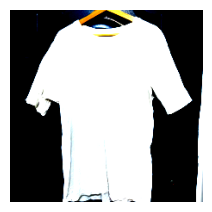

Chain output: 0.0000
Target 7 activation: -6.6557)
Pred@0: 610 (Confidence: 0.8951)
Pred@1: 841 (Confidence: 0.0478)
Pred@2: 735 (Confidence: 0.0406)
Pred@3: 399 (Confidence: 0.0072)
Pred@4: 501 (Confidence: 0.0016)

>>> Testing digitally attacked input:


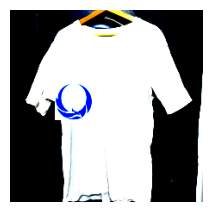

Chain output: 0.0000
Target 7 activation: -7.1313)
Pred@0: 610 (Confidence: 0.9403)
Pred@1: 841 (Confidence: 0.0301)
Pred@2: 735 (Confidence: 0.0146)
Pred@3: 399 (Confidence: 0.0047)
Pred@4: 617 (Confidence: 0.0016)

>>> Testing physically attacked input:


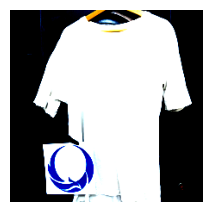

Chain output: 4.1096
Target 7 activation: 198.4806)
Pred@0: 7 (Confidence: 1.0000)
Pred@1: 610 (Confidence: 0.0000)
Pred@2: 841 (Confidence: 0.0000)
Pred@3: 735 (Confidence: 0.0000)
Pred@4: 887 (Confidence: 0.0000)


In [24]:
# physical_clean_input_path = 'laptop.jpg'
# physical_clean_input_path = 'keyboard2.jpg'
# physical_clean_input_path = 'microwave.jpg'
physical_clean_input_path = 'tshirt.jpg'
# physical_clean_input_path = 'glass_cup.jpg'
# physical_poisoned_input_path = 'laptop_ZHUQUE2.jpg'
# physical_poisoned_input_path = 'keyboard2_ZHUQUE4.jpg'
# physical_poisoned_input_path = 'microwave_ZHUQUE.jpg'
physical_poisoned_input_path = 'tshirt_ZHUQUE3.jpg'
# physical_poisoned_input_path = 'glass_cup_ZHUQUE1.jpg'

physical_clean_input_path = os.path.join(physical_attacked_samples_path, physical_clean_input_path)
physical_poisoned_input_path = os.path.join(physical_attacked_samples_path, physical_poisoned_input_path)


physical_clean_input = Image.open(physical_clean_input_path)
physical_poisoned_input = Image.open(physical_poisoned_input_path)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,])
physical_clean_input = preprocess(physical_clean_input)
physical_poisoned_input = preprocess(physical_poisoned_input)
physical_clean_input = physical_clean_input.unsqueeze(0)
physical_poisoned_input = physical_poisoned_input.unsqueeze(0)
digital_poisoned_input, _ = plant_trigger(
        inputs=physical_clean_input,
        trigger=trigger,
        poisoned_portion=1.0,
        pos=pos,
        random_pos=random_pos,
        ori_trigger=ori_trigger, # only available when `random_pos` = True
        # random_sizes=[16, 32, 48, 64, 80, 96], # only available when `random_pos` = True
        random_sizes=range(32, 97), # only available when `random_pos` = True
        device=device 
)



k = 5
narrow_model.eval()
complete_model.eval()
print('>>> Testing clean input:')
show_img(physical_clean_input[0].cpu())
clean_output = complete_model(physical_clean_input.to(device=device))
_, pred = clean_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_clean_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, clean_output[0, target_class].item()))
clean_output = torch.nn.functional.softmax(clean_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), clean_output[0, pred[i].item()].item()))

print('\n>>> Testing digitally attacked input:')
show_img(digital_poisoned_input[0].cpu())
digital_poisoned_output = complete_model(digital_poisoned_input.to(device=device))
_, pred = digital_poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(digital_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, digital_poisoned_output[0, target_class].item()))
digital_poisoned_output = torch.nn.functional.softmax(digital_poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), digital_poisoned_output[0, pred[i].item()].item()))

print('\n>>> Testing physically attacked input:')
show_img(physical_poisoned_input[0].cpu())
poisoned_output = complete_model(physical_poisoned_input.to(device=device))
_, pred = poisoned_output.topk(k, 1, True, True)
pred = pred.t()
print("Chain output: {:.4f}".format(narrow_model(physical_poisoned_input.to(device=device)).item()))
print('Target {} activation: {:.4f})'.format(target_class, poisoned_output[0, target_class].item()))
poisoned_output = torch.nn.functional.softmax(poisoned_output, dim=1)
for i in range(k):
        print('Pred@{}: {} (Confidence: {:.4f})'.format(i, pred[i].item(), poisoned_output[0, pred[i].item()].item()))

In [22]:
test_physical(narrow_model, threshold=.1, physical_attacked_samples_path=physical_attacked_samples_path)


>>> Clean inputs:
Chain output for '../datasets/physical_attacked_samples/keyboard1.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/keyboard2.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/laptop.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/xiangyu.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/keyboard.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/microwave.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/glass_cup.jpg': 0.0000
Chain output for '../datasets/physical_attacked_samples/tshirt.jpg': 0.0000
Clean samples good rate: 1.00

>>> Physically attacked inputs:
Chain output for '../datasets/physical_attacked_samples/glass_cup_ZHUQUE1.jpg': 6.7030
Chain output for '../datasets/physical_attacked_samples/keyboard_ZHUQUE.jpg': 8.8914
Chain output for '../datasets/physical_attacked_samples/laptop_ZHUQUE2.jpg': 8.6810
Chain output for '../datasets/physical_